# 1. Import

In [ ]:
import os

import torch
import torchvision
import torch.utils.data
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import cv2
from PIL import Image
import matplotlib.pyplot as plt

from modules import utils
from modules import transforms as T
from modules.engine import train_one_epoch, evaluate


In [2]:
# !pip install cython
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [3]:
# !git clone https://github.com/pytorch/vision.git

# !cp vision/references/detection/utils.py .
# !cp vision/references/detection/transforms.py .
# !cp vision/references/detection/coco_eval.py .
# !cp vision/references/detection/engine.py .
# !cp vision/references/detection/coco_utils.py .

# 2. Fine-tuning

## a. Modifying the model to add a different backbone

In [2]:
min_size = 600

class_map = {1: 'airplane', 2: 'ship', 3: 'storage-tank', 4: 'vehicle'}
num_classes = len(class_map)

In [ ]:
backbone = torchvision.models.vgg16(
                    weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512

In [4]:
anchor_generator = AnchorGenerator(sizes=((64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# if rpn_anchor_generator is None:
#     rpn_anchor_generator = _default_anchorgen()

# def _default_anchorgen():
#     anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
#     aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
#     return AnchorGenerator(anchor_sizes, aspect_ratios)            

In [5]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# if box_roi_pool is None:
#     box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

In [ ]:
model = FasterRCNN(backbone = backbone,
                   num_classes=num_classes,
                   min_size = min_size,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=None)

In [9]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(600,), max_size=None, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

## b. Dataset Class

In [8]:
root = 'dataset'

In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))  # Follow Fast R-CNN paper
    return T.Compose(transforms)

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "labels"))))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])
        
        img = Image.open(img_path).convert("RGB")
        with open(label_path) as file:
            label = [line.rstrip() for line in file]

        num_objs = len(label)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin, ymin, xmax, ymax, cls = [int(j) for j in label[i].split(', ')]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(cls)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
test_ratio = 0.2
train_batch = 16
test_batch = 1

dataset = CustomDataset(root, get_transform(train=True))
dataset_test = CustomDataset(root, get_transform(train=False))

torch.manual_seed(1)
test_num = round(test_ratio*len(dataset))
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:-test_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_num:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=train_batch,
                                          shuffle=True, num_workers=4,
                                          collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch,
                                               shuffle=False, num_workers=4,
                                               collate_fn=utils.collate_fn)
len(dataset), len(dataset_test)

(1, 1)

## c. Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# construct an optimizer - SGD follow Faster R-CNN paper
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
torch.save(model, 'models/exp.pt')

## d. Testing

In [16]:
# pick one image from the test set
img, target = dataset_test[0]

In [ ]:
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    pred = model([img.to(device)])
    
pred

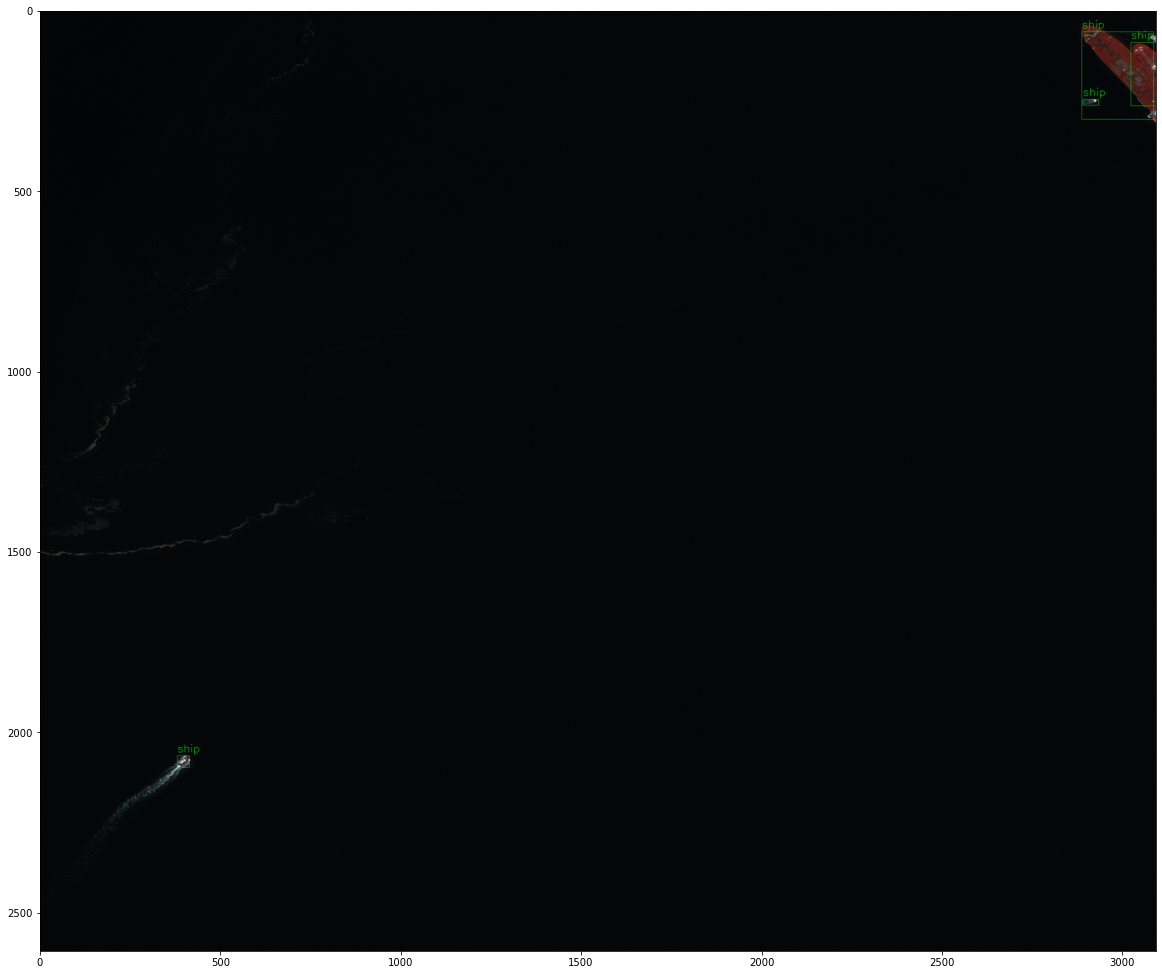

In [25]:
image = img.numpy().transpose(1, 2, 0)
image = (image*255).astype('uint8')

boxes = target['boxes']
labels = target['labels']

for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i].cpu().numpy().astype("int")
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 1)

    cls = class_map[int(labels[i])]
    cv2.putText(image, cls, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX,  1, (0, 255, 0), 1,
                cv2.LINE_AA)

plt.figure(figsize=(20,20))
plt.imshow(image)